--
title: Multilevel modeling with binomial GLM
mathjax: True
--

I've been on a journey learning multilevel models and Bayesian inference through [Richard McElreath's Statistical Rethinking book](https://xcelab.net/rm/statistical-rethinking/). The concepts of shrinkage and partial pooling that are inherent to multilevel models are really interesting to me. First, let's get some terminology out of the way. As Dr. McElreath highlights, there are multiple terms that are used for multilevel models.
- heirarchical models
- mixed-effects models
- varying effects models

Be mindful though because other authors may have different definitions for these terms. In this post, I will use these terms interchangeably as Dr. McElreath does. Regardless of how they're called, multilevel models use information sharing based on grouping variables to make more accurate estimates, especially when groups are of variable sizes. These concepts only made sense to me after working through a problem. Let's look at the impact of a multilevel model structure using a binomial generalized linear model (GLM) example from the book. Dr. McElreath uses the "tadpole data", but here I'll use problem 13H1 which has similar concepts. This question illustrates use of "varying intercepts", which is the simplest kind of varying effects model.

In [57]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
from scipy.special import logit
from scipy.optimize import curve_fit
from causalgraphicalmodels import CausalGraphicalModel
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [58]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
sns.set_context("talk")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [59]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Problem description

*The description of problem 13H1 is taken directly from the book.*

 > In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 2000, a typical Bengali woman had only 2 or 3. You’re going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in `data(bangladesh)` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on two of them for this practice problem:

> 1. `district`: ID number of administrative district each woman resided in
> 2. `use.contraception`: An indicator (0/1) of whether the woman was using contraception

> The first thing to do is ensure that the cluster variable, `district`, is a contiguous set of integers. Recall that these values will be index values inside the model. If there are gaps, you’ll have parameters for which there is no data to inform them. Worse, the model probably won’t run. Look at the unique values of the `district` variable:

```
# R code 13.40
sort(unique(d$district)) 
[1] 1 2 3 4 5 ... 51 52 53 55 56 57.... 61
```

> District 54 is absent. So `district` isn’t yet a good index variable, because it’s not contiguous. This is easy to fix. Just make a new variable that is contiguous. This is enough to do it:

```
# R code 13.41
d$district_id  <-as.integer(as.factor(d$district))
sort(unique(d$district_id))
[1] 1 2 3 4 5 ... 60
```

> Now there are 60 values, contiguous integers 1 to 60. Now, focus on predicting `use.contraception`, clustered by `district_id`. Fit both (1) a traditional fixed-effects model that uses an index variable for district and (2) a multilevel model with varying intercepts for district. Plot the predicted proportions of women in each district using contraception, for both the fixed-effects model and the varying-effects model. That is, make a plot in which district ID is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer them on the same plot, as you prefer. How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme cases of disagreement, both why they happen where they do and why the models reach different inferences?

This problem provides some nice opportunities for how multilevel models work so I'll make some additional plots in addition to what the question asks for. Let's dive in!

## Data exploration and setup

In [60]:
df_bangladesh = pd.read_csv(
    "../pymc3_ed_resources/resources/Rethinking/Data/bangladesh.csv",
    delimiter=";",
)
df_bangladesh.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


<IPython.core.display.Javascript object>

The dataframe has several columns, but for this problem, we'll focus on only the outcome variable `use.contraception` and the `district` feature. Note how each row represents one woman.

In [61]:
print("shape of df: ", df_bangladesh.shape)

shape of df:  (1934, 6)


<IPython.core.display.Javascript object>

Per the assignment, fix the district variable since it is not a contiguous set of integers.. Luckily, this is easy enough to do with `pd.Categorical`.

In [62]:
df_bangladesh["district_code"] = pd.Categorical(df_bangladesh["district"]).codes

<IPython.core.display.Javascript object>

In [63]:
# inspect and see that it's now 0-indexed for Python

print(
    "Head of the dataframe: ", df_bangladesh[["district", "district_code"]].drop_duplicates().head()
)

# and also that it accounts for missing district 54
print(
    "Tail: of the dataframe ", df_bangladesh[["district", "district_code"]].drop_duplicates().tail(10)
)

Head of the dataframe:       district  district_code
0           1              0
117         2              1
137         3              2
139         4              3
169         5              4
Tail: of the dataframe        district  district_code
1622        51             50
1659        52             51
1720        53             52
1739        55             53
1745        56             54
1790        57             55
1817        58             56
1850        59             57
1860        60             58
1892        61             59


<IPython.core.display.Javascript object>

In [64]:
# Inspect the outcome variable
df_bangladesh["use.contraception"].value_counts()

0    1175
1     759
Name: use.contraception, dtype: int64

<IPython.core.display.Javascript object>

Now that we have a sense for how the data is structured, we can start building our models. To appreciate the mixed-effects model, we will start by creating a fixed-effects model so that we can highlight the differences between them.

## Fixed-effects model

Predict `use.contraception`. Since there are two outcomes, it makes sense to use a binomial GLM for this problem. We'll use an index variable for district and it will be an intercept only model. We are using a binomial likelihood where each observation(n) is 1, since each row of our dataset is for one woman. Alternatively, we could have used a Bernoulli. The parameter *p* is the probability of a woman using contraception. We obtain this from the linear model which is on the second line. The linear model uses the [logit function](https://en.wikipedia.org/wiki/Logit) to serve as our link function with the binomial GLM. Finally, we have a regularizing prior for $\alpha$ so that our considered values for *p* are within reason. What $\alpha$ represents in this case is the average contraception use for each district. This is *regardless* of any other variables that are in our dataframe because we have omitted them from our model. This point will be contrasted with a future post where we build on this problem.

**Model `mfe` equation**

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(0, 1.5) \tag{regularizing prior}$$

Now let's use `pymc` to build our model.

In [65]:
with pm.Model() as mfe:

    # alpha prior, one for each district
    a = pm.Normal("a", 0, 1.5, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mfe = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


<IPython.core.display.Javascript object>

In [66]:
# View summary of mfe model
az.summary(trace_mfe).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.052,0.205,-1.389,-0.730,0.002,0.002,10791.0,8837.0,11082.0,2622.0,1.0
a[1],-0.584,0.452,-1.287,0.134,0.005,0.005,9885.0,4432.0,9897.0,2824.0,1.0
a[2],1.240,1.156,-0.647,2.980,0.012,0.014,8647.0,3240.0,8900.0,2517.0,1.0
a[3],-0.003,0.362,-0.572,0.579,0.004,0.007,9690.0,1409.0,9763.0,2666.0,1.0
a[4],-0.569,0.330,-1.077,-0.020,0.004,0.003,8362.0,4628.0,8431.0,2847.0,1.0


<IPython.core.display.Javascript object>

Let's visualize the posterior distributions of the $\alpha$ parameter for each district.

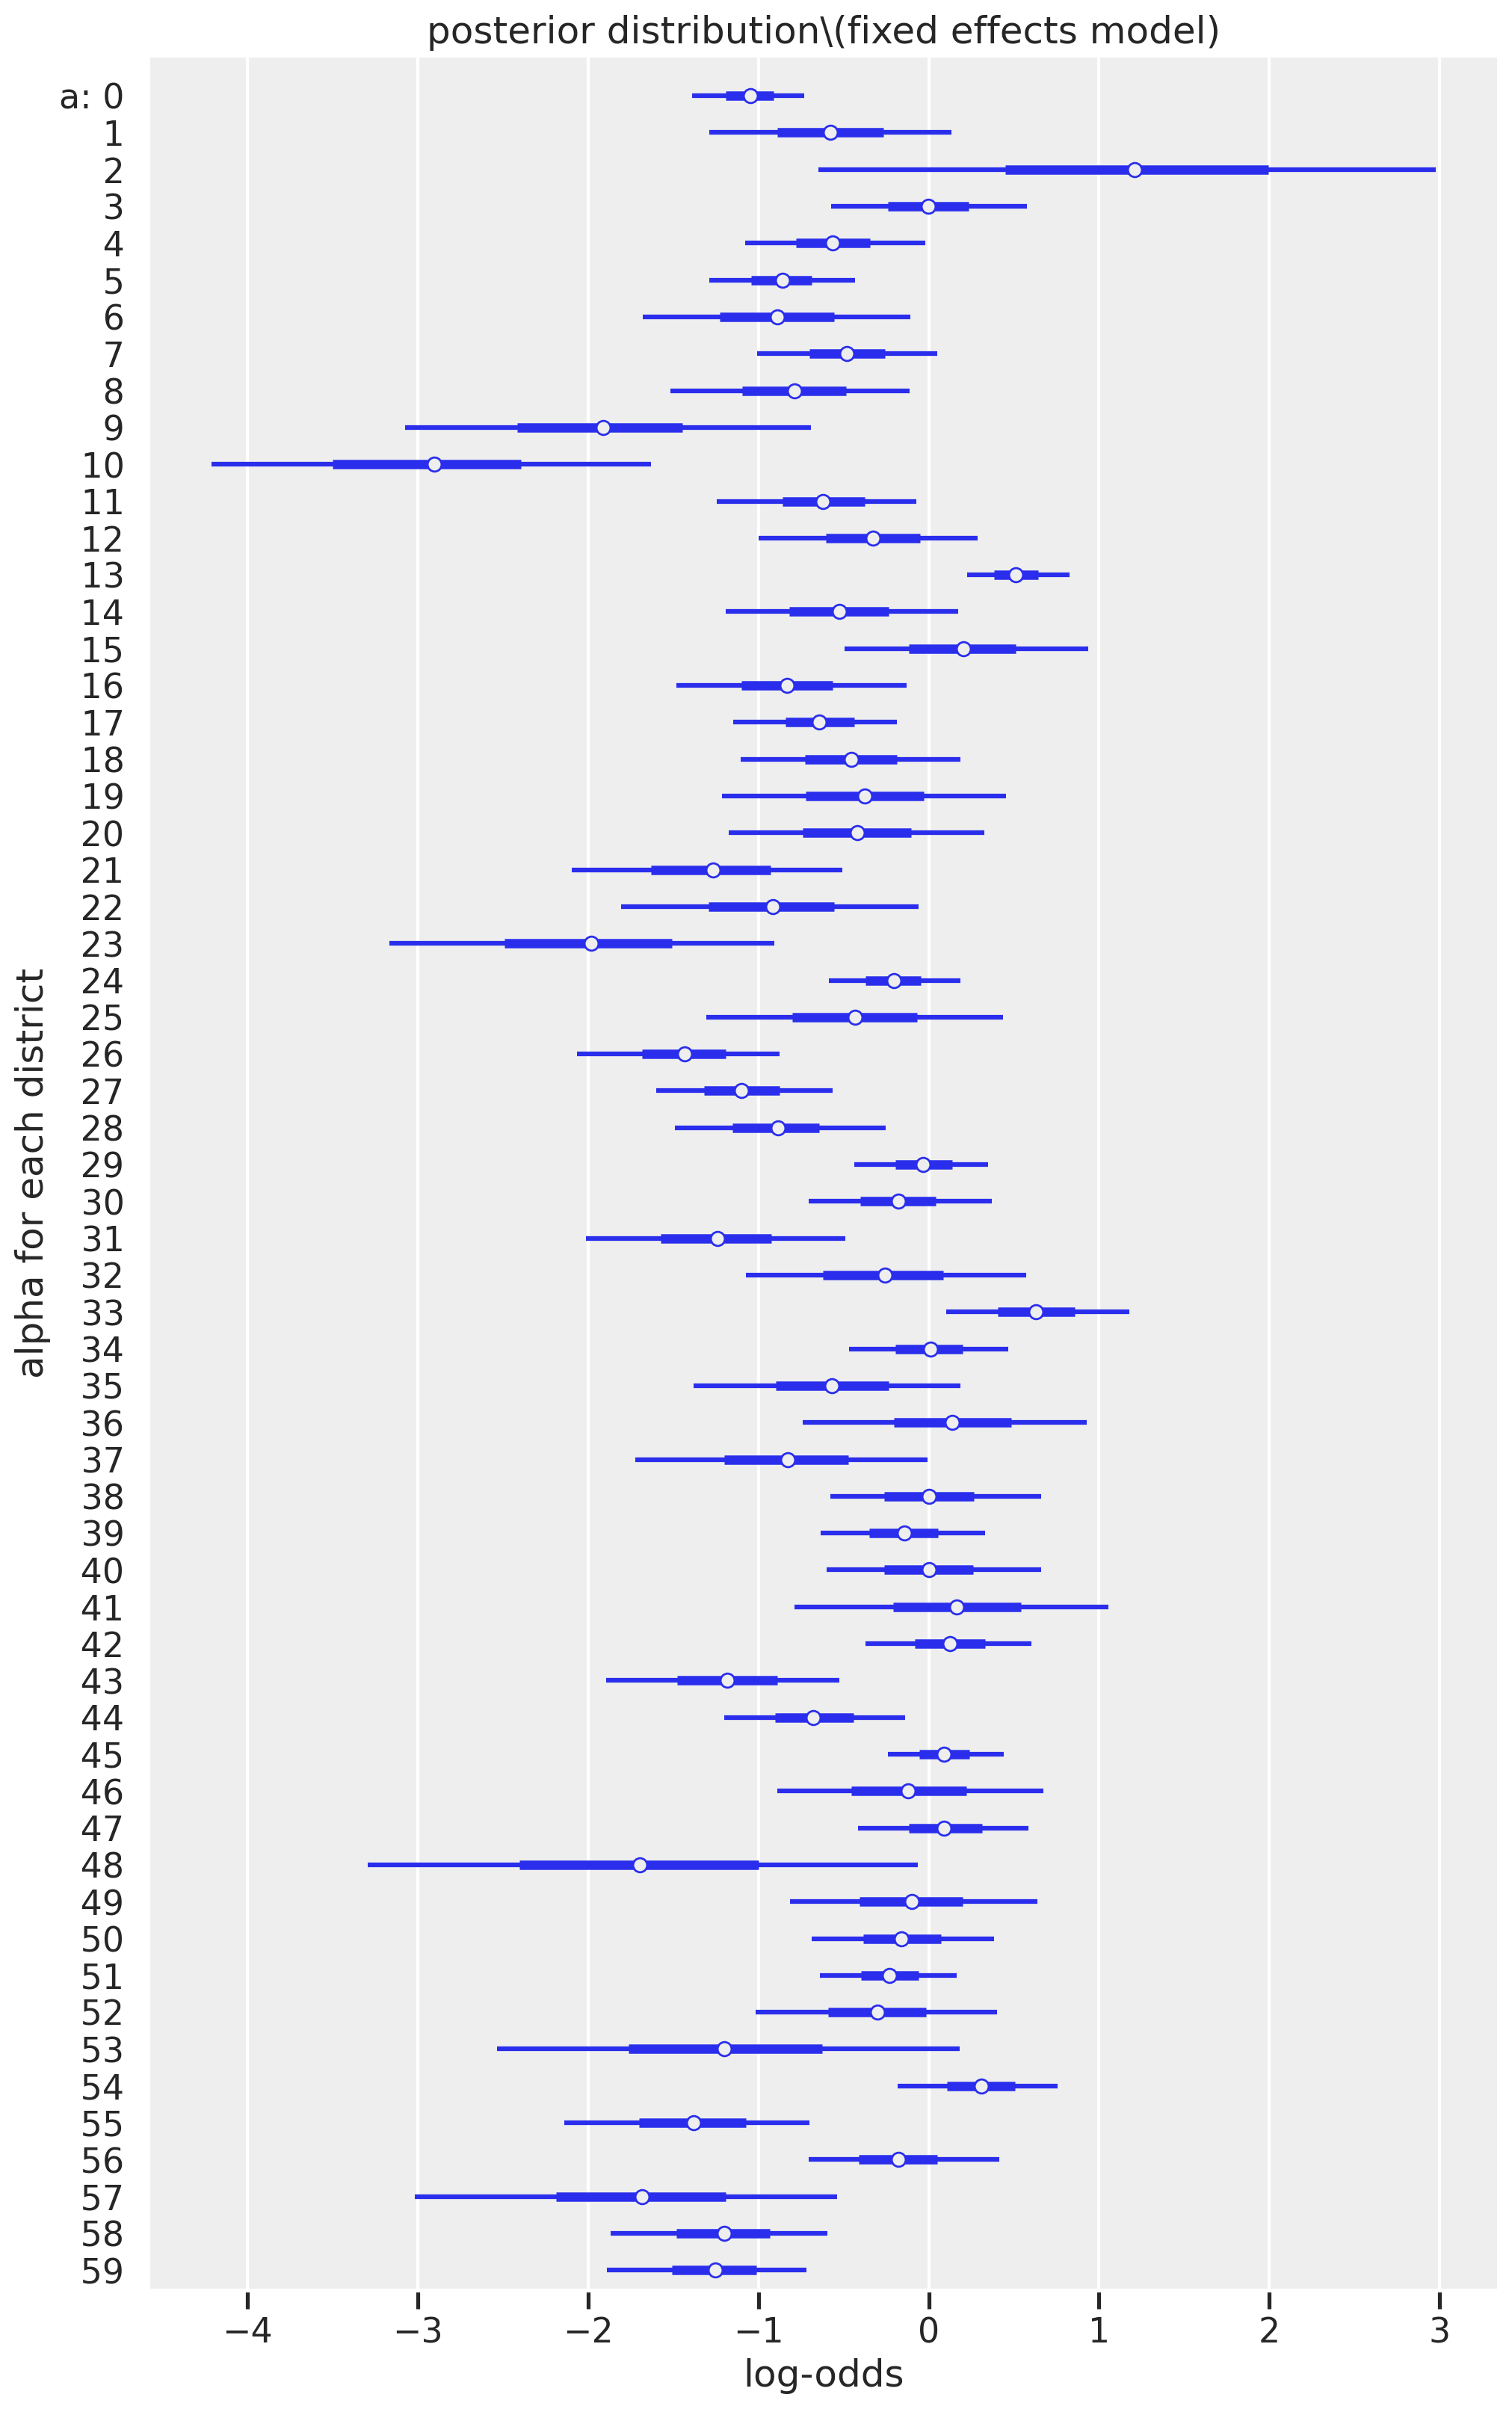

<IPython.core.display.Javascript object>

In [67]:
f, ax1 = plt.subplots(figsize=(10, 16))
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\(fixed effects model)');

We can learn a lot by looking at these results. First, it is clear that some districts are much less likely to use contraception (negative log-odds) than other districts (log-odds that span zero or are wholly positive). The district indexed as 10 (originally called district 11 of the raw dataset) has the mean with the lowest likelihood of contraceptive usage; if you inspect the raw data, no woman used contraception.

In [68]:
print("No. of district index 10 women who used contraception: ", (df_bangladesh[df_bangladesh["district_code"] == 10]['use.contraception']).sum())

No. of district index 10 women who used contraception:  0


<IPython.core.display.Javascript object>

Another point worth our focus is the width of the credible intervals, representing the uncertainty of our estimate. For example, district index 2 has a mean estimate that is the most positive among all the districts, but the credible interval is exceptionally wide, ranging from a log-ods of -0.647 to 2.980. Other districts, however, have relatively narrow confidence intervals, such as district index 13. This difference in variability can be explained by the number of women in each district. Higher counts represent lower uncertainties.

In [69]:
print("Top 5 lowest districts for counts of women:\n", df_bangladesh['district_code'].value_counts().sort_values().head())

print("Top 5 highest districts for counts of women:\n", df_bangladesh['district_code'].value_counts().sort_values().tail())

Top 5 lowest districts for counts of women:
 2      2
48     4
53     6
57    10
41    11
Name: district_code, dtype: int64
Top 5 highest districts for counts of women:
 5      65
24     67
45     86
0     117
13    118
Name: district_code, dtype: int64


<IPython.core.display.Javascript object>

While the fixed-effecs model is a reasonable approach, we can do better with a multilevel (mixed-effects) model. Let's do that next.

## Mixed-effects model

Here we can allow information to pool between clusters (districts). This would make more sense since there's a varying number of women in each district as we identified above. We would expect our district index 2 estimate to be more precise (narrower credible interval).

How can information be shared? This is where the structure of our equations can give some insight. The main change is the third line in the equations below. We're now using an **adaptive prior** that borrows information from *each* district, to make better estimates for *all* districts. Instead of specifying numerical values in our prior for $\alpha_j$, we instead replace them with new parameters. These new parameters are an "average alpha", $\bar{\alpha}$ and $\sigma$ and they have their own priors, which we call a hyperprior. Seeing how we can see parameters embedded in other parameters is how we can also appreciate the "multilevel"-ness of the multilevel model. (As McElreath states in an earlier lecture, it can become parameters all the way down.)

**Model `mme` equation**

$$C_i \sim \text{Binomial}(1, p_i) \tag{binomial likelihood}$$

$$\text{logit}(p_i) = \alpha_{\text{district}[i]} \tag{linear model using logit link}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{regularizing hyperprior}$$

$$\sigma \sim \text{Exponential}(1) \tag{regularizing hyperprior}$$

In [70]:
# multilevel model
with pm.Model() as mme:

    # prior for average district
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    # prior for SD of districts
    sigma = pm.Exponential("sigma", 1.0)

    # alpha priors for each district
    a = pm.Normal("a", a_bar, sigma, shape=len(df_bangladesh["district_code"].unique()))

    # link function
    p = pm.math.invlogit(a[df_bangladesh["district_code"]])

    # likelihood, n=1 since each represents an individual woman
    c = pm.Binomial("c", n=1, p=p, observed=df_bangladesh["use.contraception"])

    trace_mme = pm.sample(draws=1000, random_seed=19, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


<IPython.core.display.Javascript object>

It looks like there are no divergences here so we don't have to worry about re-parameterizing. Let's take a look now.

In [71]:
# View summary of mme model
az.summary(trace_mme).head()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.540,0.088,-0.679,-0.397,0.002,0.001,3125.0,3125.0,3125.0,3066.0,1.00
a[0],-0.992,0.198,-1.299,-0.679,0.003,0.002,5931.0,5154.0,5973.0,2419.0,1.00
a[1],-0.599,0.360,-1.144,-0.001,0.004,0.004,7047.0,3716.0,7138.0,2443.0,1.01
a[2],-0.240,0.501,-1.003,0.559,0.006,0.008,7605.0,2191.0,7501.0,3176.0,1.00
a[3],-0.179,0.298,-0.652,0.309,0.004,0.004,6683.0,2486.0,6638.0,3036.0,1.00


<IPython.core.display.Javascript object>

Let's visualize by plotting the mixed effects model posterior side-by-side with the fixed-effects model that we already visualized above. This will help us appreciate the impact of the multilevel model structure.

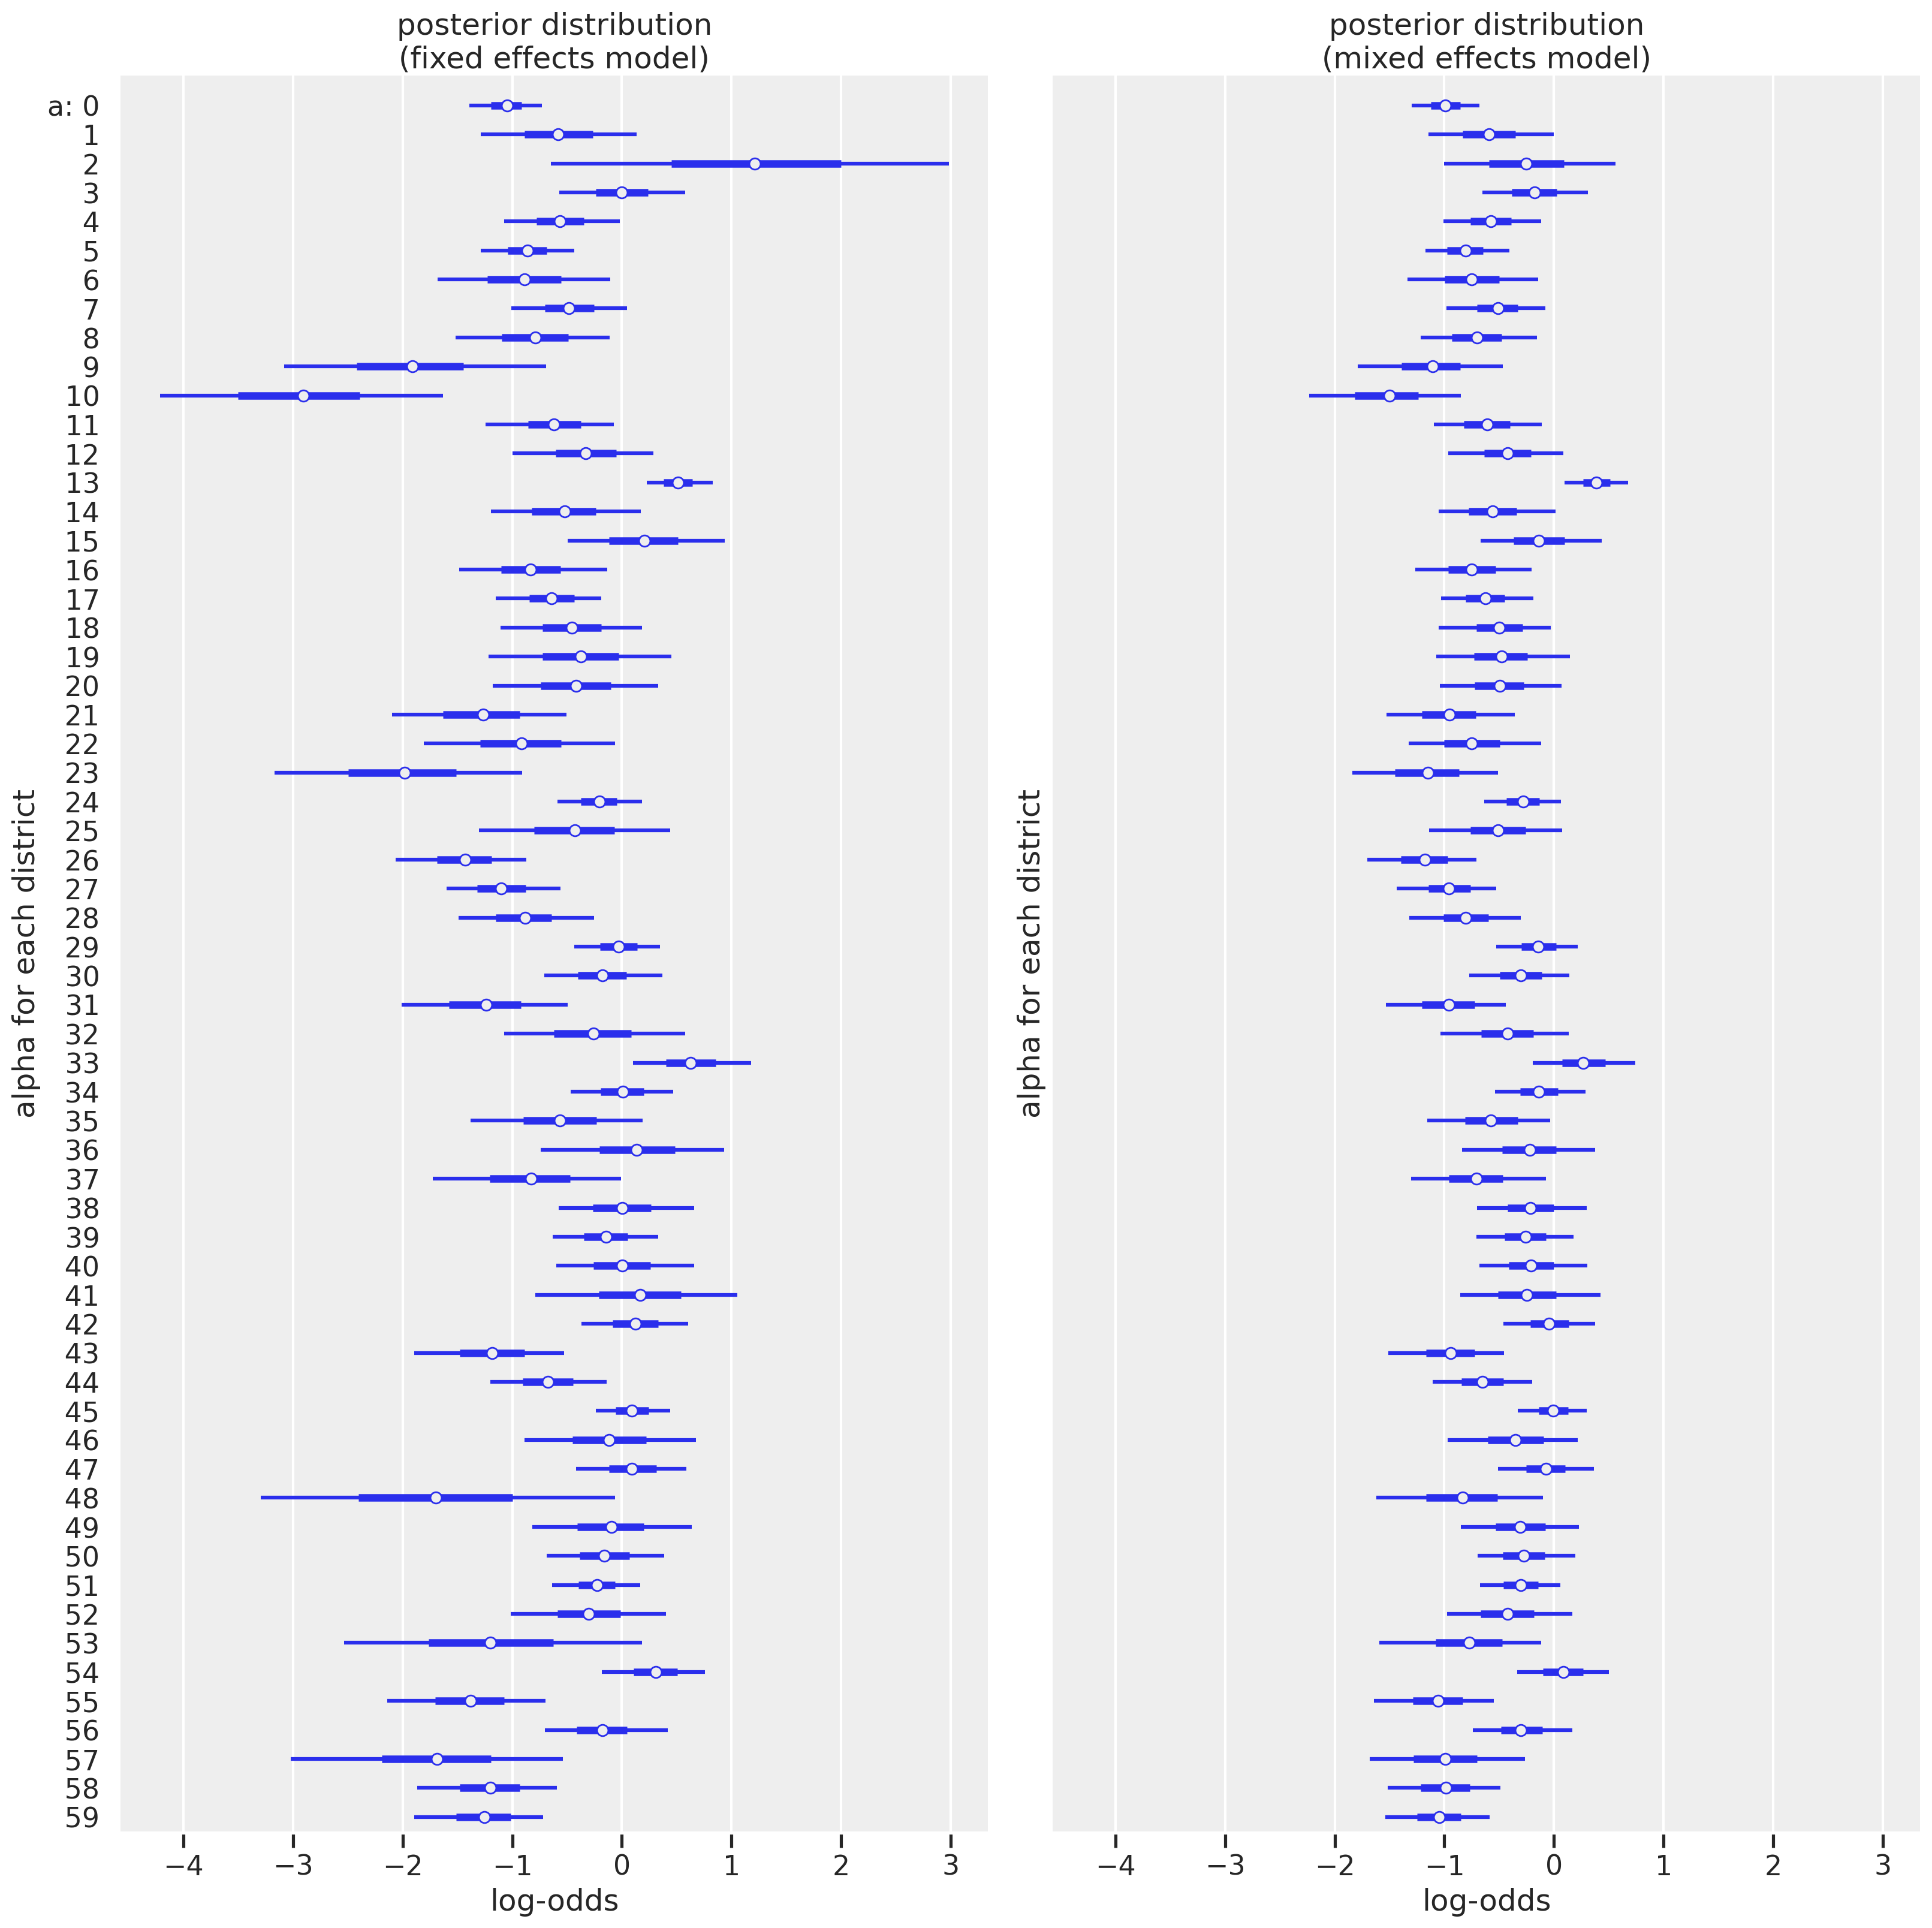

<IPython.core.display.Javascript object>

In [72]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16), sharex=True, sharey=True)
az.plot_forest(trace_mfe, combined=True, ax=ax1)
ax1.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\n(fixed effects model)')

az.plot_forest(trace_mme, var_names='a', combined=True, ax=ax2)
ax2.set(xlabel="log-odds", ylabel="alpha for each district", title='posterior distribution\n(mixed effects model)');

The first thing that jumps out is that the uncertainty for several districts now is much smaller, particularly those with small sample sizes like district index 2. This is where the multilevel model really shines. Another change is that we see the mean estimates get pulled towards the center, especially those with more extreme values in the fixed effects models. It may be harder to appreciate in this visualization but we'll plot on the outcome scale. Let's explore these differences in different ways.

Let's look more closely at how sample size impacts the uncertainty for each district in the fixed-effects versus mixed-effects model for each district.

In [73]:
# Create a new dataframe
col2inspect = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = (
    pd.merge(
    az.summary(trace_mfe)[col2inspect],
    az.summary(trace_mme)[col2inspect],
    how="inner",
    left_index=True,
    right_index=True)
    .reset_index(drop=True)
)

# Add number of women for each district
df_summary["n_women"] = df_bangladesh.groupby("district_code").count().iloc[:, 0]
# Inspect
df_summary.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,n_women
0,-1.052,0.205,-1.389,-0.730,-0.992,0.198,-1.299,-0.679,117
1,-0.584,0.452,-1.287,0.134,-0.599,0.360,-1.144,-0.001,20
2,1.240,1.156,-0.647,2.980,-0.240,0.501,-1.003,0.559,2
3,-0.003,0.362,-0.572,0.579,-0.179,0.298,-0.652,0.309,30
4,-0.569,0.330,-1.077,-0.020,-0.577,0.279,-1.007,-0.118,39


<IPython.core.display.Javascript object>

[(0.0, 1.2),
 (0.0, 1.2),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD'),
 Text(0.5, 1.0, 'Impact of sample size on SD')]

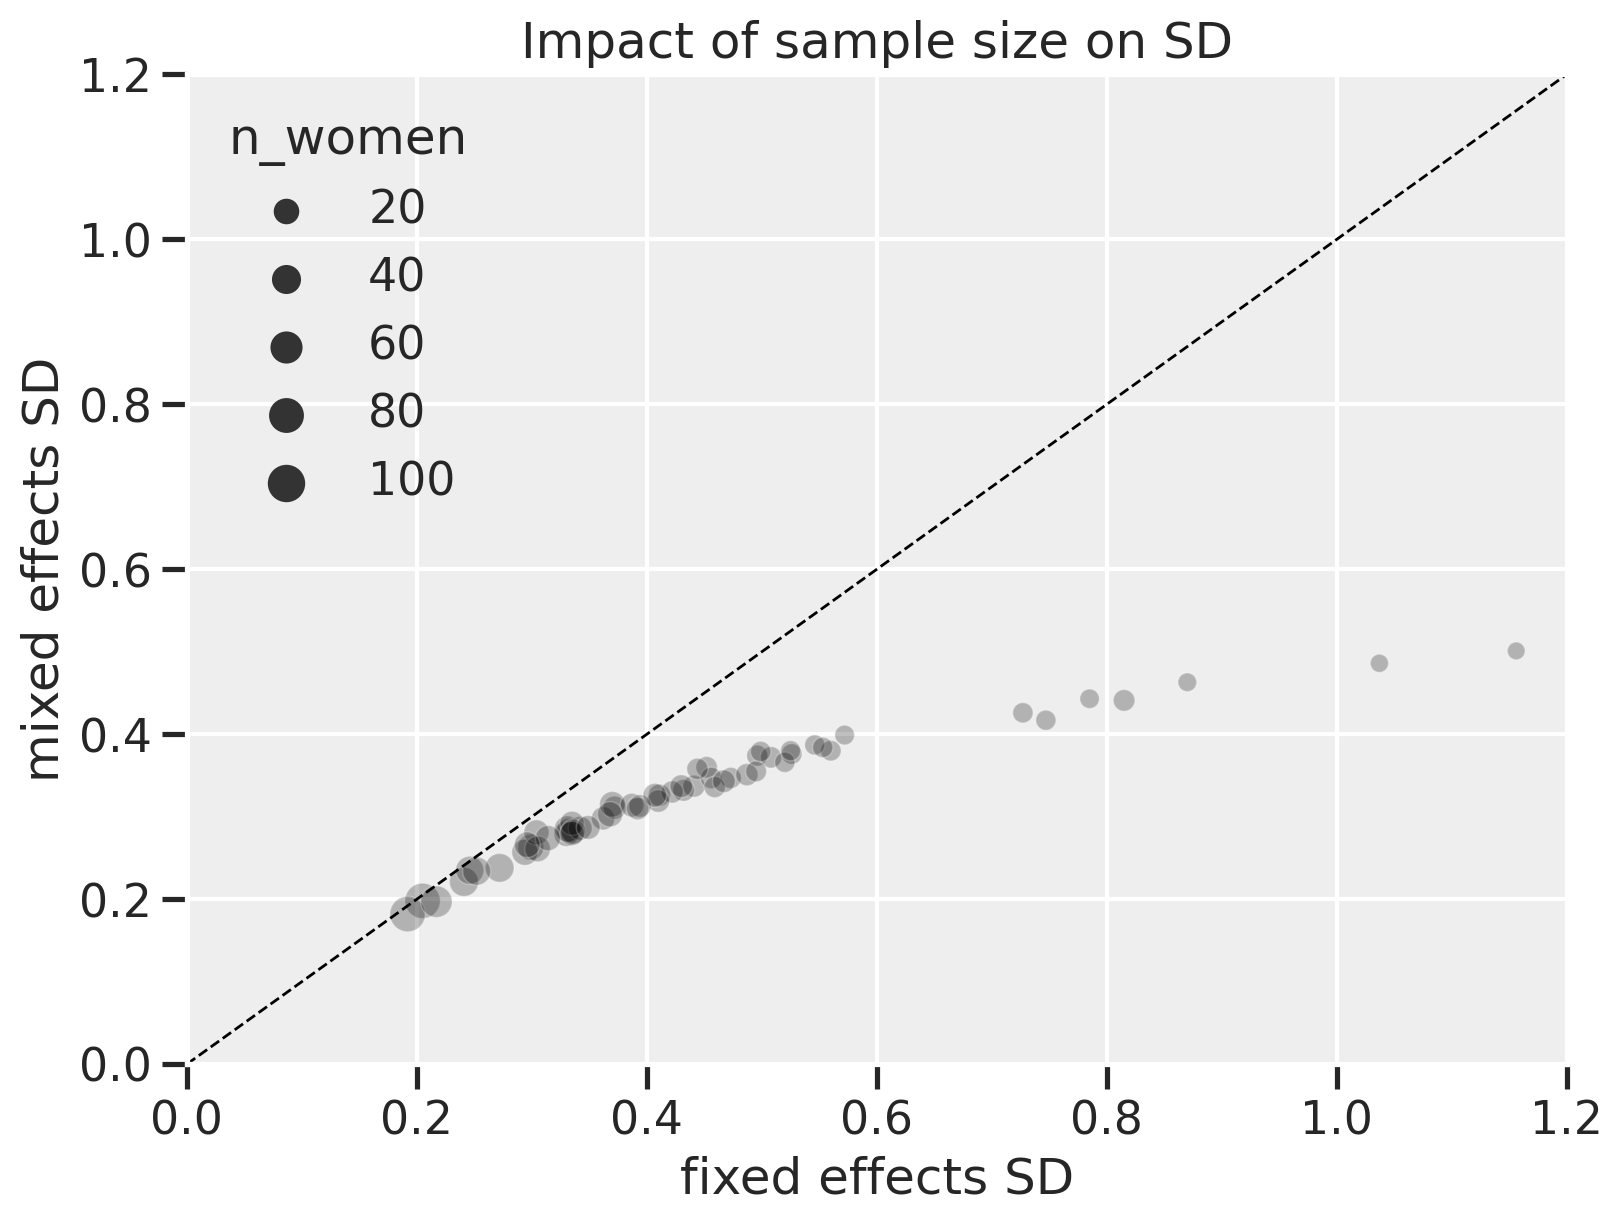

<IPython.core.display.Javascript object>

In [74]:
f, ax1 = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    data=df_summary, x="sd_x", y="sd_y", size="n_women", color="black", alpha=0.25, ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD", title="Impact of sample size on SD"
)

On the x-axis are the standard deviations of the $\alpha$ values for each district in the fixed effects model. On the y-axis are the corresponding SD values for the mixed effects model. The size of the points are the number of women in each district. The dashed diagonal line represents where values between the x and y-axes are equal.

Here, we can see that the fixed effects model shows greater uncertainty, especially when the number of women in each district gets lower (points at the right of the plot). The lower uncertainty with mixed effects is due to partial pooling. When the number of women is high, the mixed effects model shows uncertainty on par with the fixed effects model, meaning there's "less benefit" to using a mixed effects model but it also doesn't hurt.

Now, let's plot on the outcome scale. Here, we'll show the predicted proportion of women in each district using contraception with fixed-effects and mixed-effects estimates shown side-by-side. We'll use the `logistic` function to transform the log-odds back on the probability scale.

[(-2.0, 60.0),
 (0.0, 1.0),
 Text(0.5, 0, 'district index'),
 Text(0, 0.5, 'proportion predicted\nfor contraception use')]

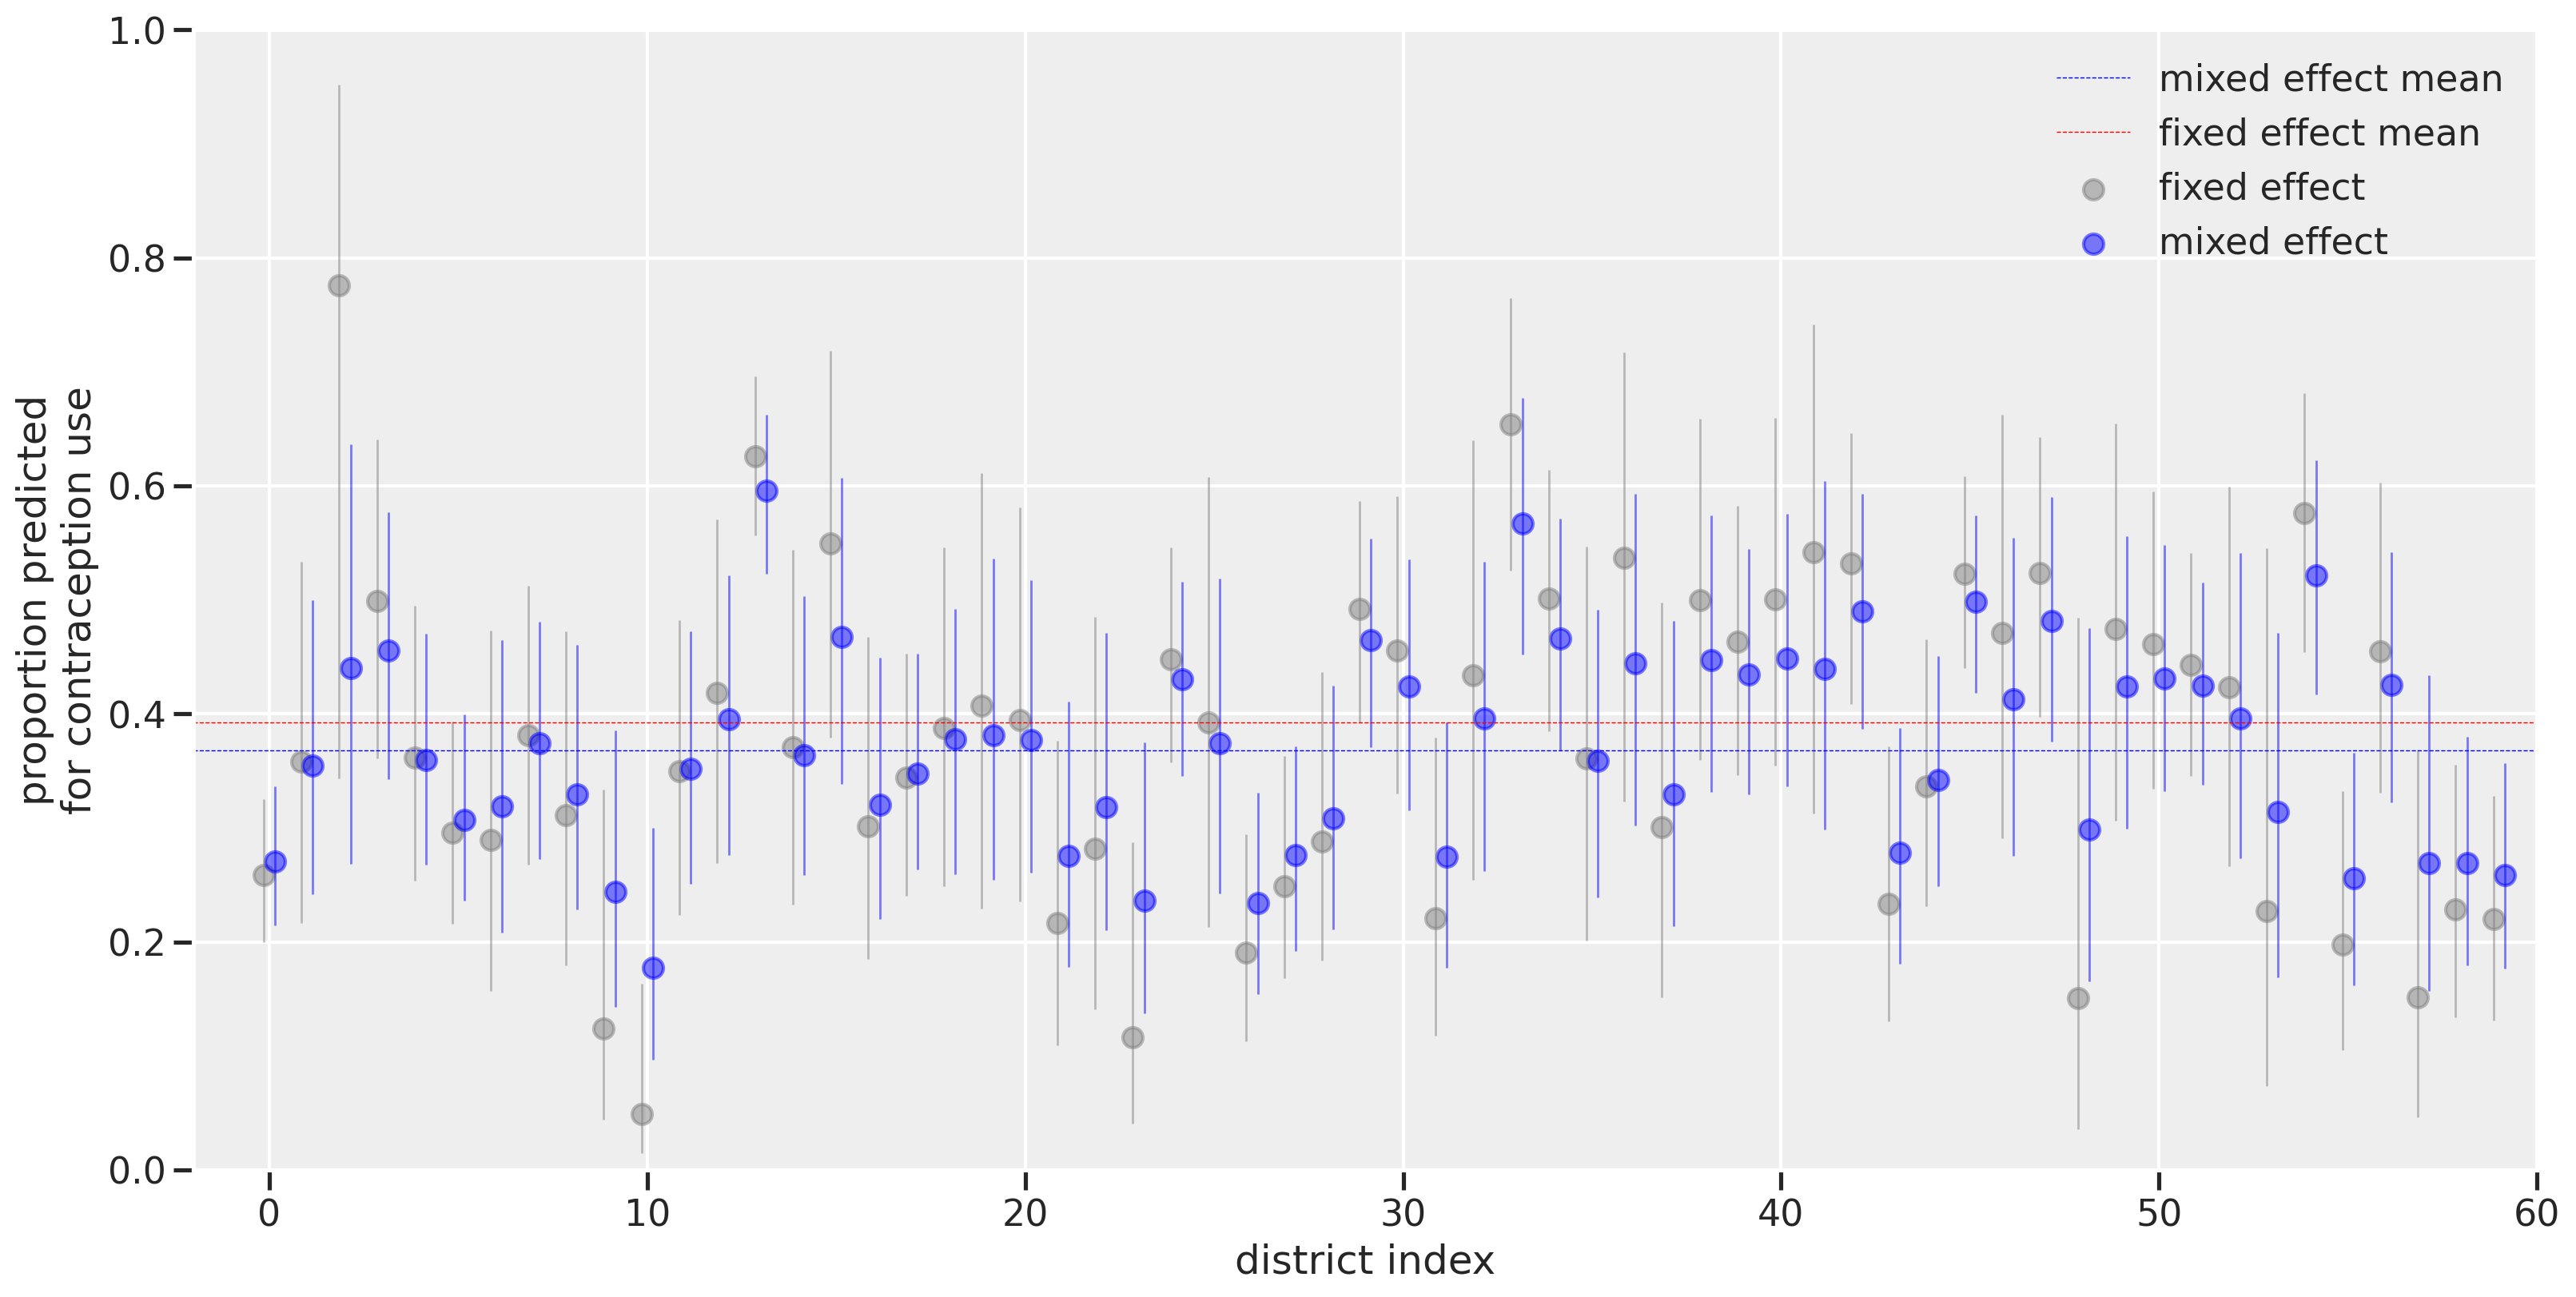

<IPython.core.display.Javascript object>

In [75]:
f, ax1 = plt.subplots(figsize=(16, 8))

# Plot means
ax1.scatter(
    df_summary.index - 0.15,
    logistic(df_summary["mean_x"]),
    color="gray",
    alpha=0.5,
    label="fixed effect",
)
ax1.scatter(
    df_summary.index + 0.15,
    logistic(df_summary["mean_y"]),
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.vlines(
    x=df_summary.index - 0.15,
    ymin=logistic(df_summary["hdi_5.5%_x"]),
    ymax=logistic(df_summary["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
    alpha=0.5,
)

ax1.vlines(
    x=df_summary.index + 0.15,
    ymin=logistic(df_summary["hdi_5.5%_y"]),
    ymax=logistic(df_summary["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
    alpha=0.5,
)

# Plot average mixed effect line
me_mean = logistic(az.summary(trace_mme).loc["a_bar", "mean"])
ax1.plot(
    [-10, 62],
    [me_mean, me_mean],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_bangladesh["use.contraception"].mean()
ax1.plot(
    [-10, 62],
    [fe_mean, fe_mean],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend()
ax1.set(
    xlim=[-2, 60],
    ylim=[0, 1],
    xlabel="district index",
    ylabel="proportion predicted\nfor contraception use",
)

The district index is shown on the x-axis while the proportion predicted for contraception use is on the y-axis. Visualizing on this scale makes it more directly interpretable than log-odds when thinking about the proportion of women using contraception. The horizontal dashed lines represent the overall means for fixed effect (red) versus the mixed effect (blue). The difference in the lines is due to leveraging the sample size differences. As we had seen with the log-odds scale, the districts with the smallest number of women (like district index 2) had their estimates greatly affected by using a multilevel model. The estimates get pulled towards the horizontal blue dashed line, illustrating the concept of **shrinkage** that results from the **partial pooling** of information across estimates.

In this post, we covered a simple example of multilevel modeling using a binomial GLM. We used a dataset where clusters (districts) contained variable sample sizes. By contrasting a fixed effects model with a mixed effects model, we can see how multilevel modeling improves our estimates and reduces uncertainty. Here, we covered an example of varying intercepts. In a later post, we'll add varying slopes which will help us incorporate predictor variables.

Appendix: Environment and system parameters

In [76]:
%watermark -n -u -v -iv -w

Last updated: Sat Oct 23 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
numpy     : 1.20.1
scipy     : 1.6.0
seaborn   : 0.11.1
matplotlib: 3.3.4
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pymc3     : 3.11.0
arviz     : 0.11.1
theano    : 1.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>